Import + Load Data

In [42]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv("movies_metadata.csv", low_memory=False)
df_raw.shape, df_raw.columns[:15]

((45466, 24),
 Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
        'imdb_id', 'original_language', 'original_title', 'overview',
        'popularity', 'poster_path', 'production_companies',
        'production_countries', 'release_date'],
       dtype='object'))

Keeping relevant columns

In [43]:
use_cols = [
    "budget", "revenue", "runtime", "release_date",
    "original_language", "genres"
]

df = df_raw[use_cols].copy()
df.head()

,budget,revenue,runtime,release_date,original_language,genres
0,30000000,373554033.0,81.0,1995-10-30,en,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,65000000,262797249.0,104.0,1995-12-15,en,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,0,0.0,101.0,1995-12-22,en,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,16000000,81452156.0,127.0,1995-12-22,en,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,0,76578911.0,106.0,1995-02-10,en,"[{'id': 35, 'name': 'Comedy'}]"


Clean numeric columns (budget/revenue/runtime)

In [44]:
def to_num(s):
    return pd.to_numeric(s, errors="coerce")

df["budget"] = to_num(df["budget"])
df["revenue"] = to_num(df["revenue"])
df["runtime"] = to_num(df["runtime"])

df[["budget","revenue","runtime"]].describe()

,budget,revenue,runtime
count,4.546300e+04,4.546000e+04,45203.000000
mean,4.224579e+06,1.120935e+07,94.128199
std,1.742413e+07,6.433225e+07,38.407810
min,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,85.000000
50%,0.000000e+00,0.000000e+00,95.000000
75%,0.000000e+00,0.000000e+00,107.000000
max,3.800000e+08,2.787965e+09,1256.000000


Extract release_year

In [45]:
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["release_year"] = df["release_date"].dt.year

df[["release_date","release_year"]].head()

,release_date,release_year
0,1995-10-30,1995.0
1,1995-12-15,1995.0
2,1995-12-22,1995.0
3,1995-12-22,1995.0
4,1995-02-10,1995.0


Extract main_genre

In [46]:
import ast

def get_main_genre(x):
    if pd.isna(x):
        return np.nan
    try:
        items = ast.literal_eval(x)  # list of dicts
        if isinstance(items, list) and len(items) > 0 and "name" in items[0]:
            return items[0]["name"]
    except Exception:
        return np.nan
    return np.nan

df["main_genre"] = df["genres"].apply(get_main_genre)
df[["genres","main_genre"]].head(10)

,genres,main_genre
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Animation
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",Adventure
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",Romance
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Comedy
4,"[{'id': 35, 'name': 'Comedy'}]",Comedy
5,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Action
6,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",Comedy
7,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",Action
8,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",Action
9,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",Adventure


Create target hit + basic filtering

In [47]:
# Keep rows with meaningful budget, allow revenue=0 (so we include flops)
df = df.dropna(subset=["budget", "runtime", "release_year", "original_language", "main_genre"]).copy()

df["budget"] = pd.to_numeric(df["budget"], errors="coerce")
df["revenue"] = pd.to_numeric(df["revenue"], errors="coerce").fillna(0)

df = df[(df["budget"] > 0) & (df["runtime"] > 0)].copy()

# (Optional but recommended) remove extreme outliers
df = df[df["budget"] <= df["budget"].quantile(0.99)].copy()
df = df[df["revenue"] <= df["revenue"].quantile(0.99)].copy()

# Better "hit" definition (profitability margin)
df["hit"] = (df["revenue"] >= df["budget"]).astype(int)

df["hit"].value_counts(), df.shape

(hit
 0    5004
 1    3602
 Name: count, dtype: int64,
 (8606, 9))

Quick EDA

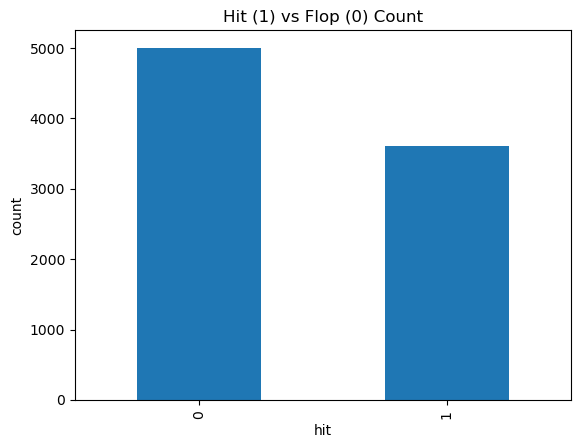

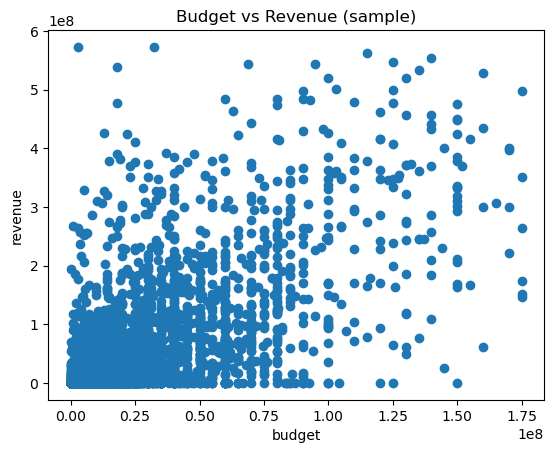

In [48]:
import matplotlib.pyplot as plt

# Class balance
df["hit"].value_counts().plot(kind="bar")
plt.title("Hit (1) vs Flop (0) Count")
plt.xlabel("hit")
plt.ylabel("count")
plt.show()

# Budget vs Revenue (log scale scatter sample)
sample = df.sample(n=min(5000, len(df)), random_state=42)
plt.scatter(sample["budget"], sample["revenue"])
plt.title("Budget vs Revenue (sample)")
plt.xlabel("budget")
plt.ylabel("revenue")
plt.show()

Train/test split + features/target

In [49]:
from sklearn.model_selection import train_test_split

X = df[["budget", "runtime", "release_year", "original_language", "main_genre"]].copy()
y = df["hit"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((6884, 5), (1722, 5))

Preprocessing pipeline

In [50]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

num_cols = ["budget", "runtime", "release_year"]
cat_cols = ["original_language", "main_genre"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

Model 1: Logistic Regression baseline

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score

logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

logreg.fit(X_train, y_train)

pred_lr = logreg.predict(X_test)
print("LogReg F1:", f1_score(y_test, pred_lr))
print("LogReg Recall:", recall_score(y_test, pred_lr))
print(confusion_matrix(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

LogReg F1: 0.5913757700205339
LogReg Recall: 0.9986130374479889
[[  7 994]
 [  1 720]]
              precision    recall  f1-score   support

           0       0.88      0.01      0.01      1001
           1       0.42      1.00      0.59       721

    accuracy                           0.42      1722
   macro avg       0.65      0.50      0.30      1722
weighted avg       0.68      0.42      0.26      1722



Model 2: Random Forest baseline

In [52]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
print("RF F1:", f1_score(y_test, pred_rf))
print("RF Recall:", recall_score(y_test, pred_rf))
print(confusion_matrix(y_test, pred_rf))
print(classification_report(y_test, pred_rf))

RF F1: 0.5961123110151189
RF Recall: 0.5742024965325936
[[747 254]
 [307 414]]
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1001
           1       0.62      0.57      0.60       721

    accuracy                           0.67      1722
   macro avg       0.66      0.66      0.66      1722
weighted avg       0.67      0.67      0.67      1722



Hyperparameter tuning (RandomizedSearchCV) (max 3 values each)

In [53]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", None],
}

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,
    scoring="f1",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)
search.best_params_, search.best_score_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


({'model__n_estimators': 600,
  'model__min_samples_split': 10,
  'model__min_samples_leaf': 1,
  'model__max_features': 'sqrt',
  'model__max_depth': 20},
 0.6077731501842085)

Evaluate tuned model

In [54]:
best_model = search.best_estimator_

pred_best = best_model.predict(X_test)
print("Tuned RF F1:", f1_score(y_test, pred_best))
print("Tuned RF Recall:", recall_score(y_test, pred_best))
print(confusion_matrix(y_test, pred_best))
print(classification_report(y_test, pred_best))

Tuned RF F1: 0.6085693536673928
Tuned RF Recall: 0.5811373092926491
[[764 237]
 [302 419]]
              precision    recall  f1-score   support

           0       0.72      0.76      0.74      1001
           1       0.64      0.58      0.61       721

    accuracy                           0.69      1722
   macro avg       0.68      0.67      0.67      1722
weighted avg       0.68      0.69      0.68      1722



Save model + dropdown options (for Streamlit)

In [55]:
import joblib, json

joblib.dump(best_model, "model.joblib")

options = {
    "languages": sorted(df["original_language"].unique().tolist()),
    "genres": sorted(df["main_genre"].unique().tolist())
}

with open("options.json", "w") as f:
    json.dump(options, f)

print("Saved: model.joblib and options.json")

Saved: model.joblib and options.json


Quick sanity test load

In [56]:
loaded = joblib.load("model.joblib")
test_row = X_test.iloc[[0]]
loaded.predict(test_row), test_row

(array([1]),
           budget  runtime  release_year original_language main_genre
 3909  48000000.0    147.0        2000.0                en   Thriller)